In [3]:
import rioxarray as rxr
import pyproj
from pyproj import Proj, Transformer
import xarray
import numpy as np
import netCDF4 as nc
from matplotlib import pyplot

import salem

scale = 6370000 / 6378137
auDomainCRS = f"+proj=lcc +lon_0=133.302001953125 +lat_0=-27.64398193359375 +lat_1=-15.0 +lat_2=-40.0 +ellps=GRS80"
auDomainGrid = "../inputs/geo_em.d01.nc"
landUsePath = "../inputs/NLUM_ALUMV8_250m_2015_16_alb.tif"

dss = salem.open_wrf_dataset(auDomainGrid)
wrf_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                       lat_1=dss.TRUELAT1, lat_2=dss.TRUELAT2, # Cone intersects with the sphere
                       lat_0=dss.MOAD_CEN_LAT, lon_0=dss.STAND_LON, # Center point
                       a=6370000, b=6370000)

ds = nc.Dataset(auDomainGrid)
lats = ds["XLAT_C"][:]
longs = ds["XLONG_C"][:]
landmask = ds["LANDMASK"][:]

xds = xarray.open_dataset(auDomainGrid)
landUse = rxr.open_rasterio(landUsePath, masked=True)
print(landUse.rio.crs)
print(scale)

EPSG:3577
0.9987242356192725


In [7]:
import cv2   
import numpy as np
cv2.imwrite('lu.png', landUse[0].values)

True

In [6]:
nx, ny = (3, 2)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)
x, y, xv, yv

(array([0. , 0.5, 1. ]),
 array([0., 1.]),
 array([[0. , 0.5, 1. ],
        [0. , 0.5, 1. ]]),
 array([[0., 0., 0.],
        [1., 1., 1.]]))

In [170]:
NTL = "nasa-nighttime-lights.tiff"
ntl = rxr.open_rasterio(NTL, masked=True)
ntlAUDomain = ntl.rio.reproject(auDomainCRS)
ntl.rio.crs

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "rasterio/crs.pyx", line 775, in rasterio.crs.CRS.from_user_input
  File "rasterio/_err.pyx", line 209, in rasterio._err.exc_wrap_ogrerr
rasterio._err.CPLE_BaseError: OGR Error code 5

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/gerardmason/.pyenv/versions/3.11.2/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/lp/98vvxgks5n76f3jvlgtxw46m0000gn/T/ipykernel_59408/774385273.py", line 3, in <module>
    ntlAUDomain = ntl.rio.reproject(auDomainCRS)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/gerardmason/.pyenv/versions/3.11.2/lib/python3.11/site-packages/rioxarray/raster_array.py", line 436, in reproject
    dst_affine, dst_width, dst_height = _make_dst_affine(
                                        ^^^^^^^^^^^^^^^^^
  File "/Users/gerardmason

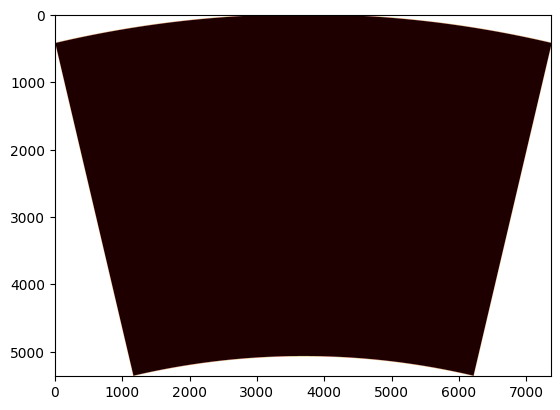

CRS.from_wkt('PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",-27.6439819335937],PARAMETER["central_meridian",133.302001953125],PARAMETER["standard_parallel_1",-15],PARAMETER["standard_parallel_2",-40],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [175]:
pyplot.imshow(ntlAUDomain[0].values, cmap="pink")
pyplot.show()
ntlAUDomain.rio.crs

In [5]:
print(landUse.shape)
# landUseAUDomain = landUse.rio.reproject(auDomainCRS)
# landUseAUDomain.rio.to_raster("AULandUse.tif", compress="lzw")
# landUseAUDomain.shape

# domainProj = Proj(auDomainCRS)
# transformer = Transformer.from_crs(landUse.rio.crs, wrf_proj.crs)
xv, yv = np.meshgrid(landUse.x.values, landUse.y.values)
transformer = Transformer.from_crs(landUse.rio.crs, wrf_proj.crs)
llxx, llyy = transformer.transform(xv, yv)
landUse.rio.crs

(1, 15669, 18633)


In [5]:
xv.shape, yv.shape

((15669, 18633), (15669, 18633))

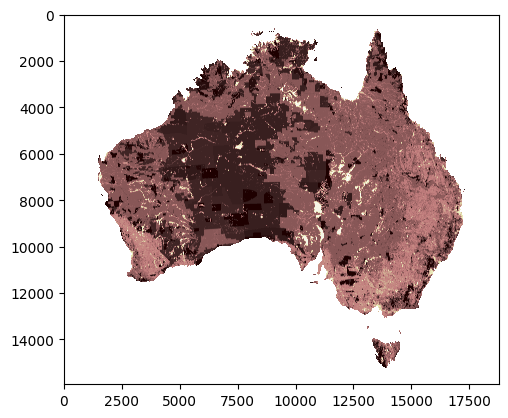

(1, 15938, 18760)

In [185]:
pyplot.imshow(landUseAUDomain[0].values, cmap="pink")
pyplot.show()
landUseAUDomain.shape

In [4]:
from matplotlib import pyplot

_, yy, xx = landmask.shape
ww = ds.DX * xx
hh = ds.DY * yy
methane = np.zeros((yy, xx))

findGrid = lambda data, totalSize, gridSize: np.floor((data + totalSize / 2) / gridSize)
xDomain = xarray.apply_ufunc(findGrid, llxx, ww, ds.DX).astype(int)
yDomain = xarray.apply_ufunc(findGrid, llyy, hh, ds.DY).astype(int)
xDomain.shape


# domainProj.to_latlong()

# x0, y0 = domainProj(116.58577444871523, -20.785145800719025)
# mx0 = int(round((x0 + ww / 2) / ds.DX))
# my0 = int(round((y0 + hh / 2) / ds.DY))
# methane[my0][mx0] = 10000

# x0, y0 = domainProj(116.12567204359542, -34.74153384087491)
# mx0 = int(round((x0 + ww / 2) / ds.DX))
# my0 = int(round((y0 + hh / 2) / ds.DY))
# methane[my0][mx0] = 10000

# pyplot.imshow(methane, cmap="pink")
# pyplot.show()

NameError: name 'llxx' is not defined

In [63]:
_, luy, lux = landUse.shape
for y in range(0, luy):
    for x in range(0, lux):
       methane[yDomain[y]][xDomain[x]] += 0.1

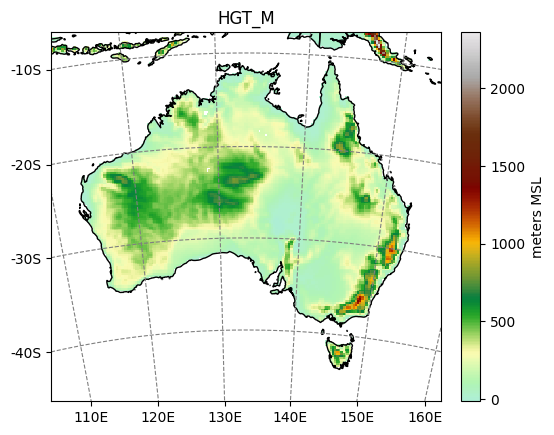

In [177]:
import salem
ds = salem.open_wrf_dataset(auDomainGrid)
ds.HGT_M.where(ds.LANDMASK).salem.quick_map(cmap='topo')

In [179]:
import pyproj
wrf_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                       lat_1=ds.TRUELAT1, lat_2=ds.TRUELAT2, # Cone intersects with the sphere
                       lat_0=ds.MOAD_CEN_LAT, lon_0=ds.STAND_LON, # Center point
                       a=6370000, b=6370000)

In [190]:
# Easting and Northings of the domains center point
wgs_proj = pyproj.Proj(proj='latlong', datum='WGS84')
e, n = pyproj.transform(wgs_proj, wrf_proj, ds.CEN_LON, ds.CEN_LAT)
# Grid parameters
dx, dy = ds.DX, ds.DY
nx, ny = ds.dims['west_east'], ds.dims['south_north']
# Down left corner of the domain
x0 = -(nx-1) / 2. * dx + e
y0 = -(ny-1) / 2. * dy + n
# 2d grid
xx, yy = np.meshgrid(np.arange(nx) * dx + x0, np.arange(ny) * dy + y0)

/var/folders/lp/98vvxgks5n76f3jvlgtxw46m0000gn/T/ipykernel_59408/2101061622.py:3: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  e, n = pyproj.transform(wgs_proj, wrf_proj, ds.CEN_LON, ds.CEN_LAT)


/var/folders/lp/98vvxgks5n76f3jvlgtxw46m0000gn/T/ipykernel_59408/1235935266.py:1: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  our_lons, our_lats = pyproj.transform(wrf_proj, wgs_proj, xx, yy)


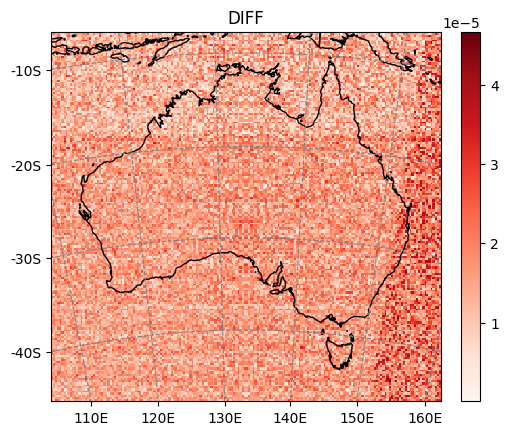

In [181]:
our_lons, our_lats = pyproj.transform(wrf_proj, wgs_proj, xx, yy)
ds['DIFF'] = np.sqrt((our_lons - ds.XLONG_M)**2 + (our_lats - ds.XLAT_M)**2)
ds.salem.quick_map('DIFF', cmap='Reds');

In [182]:
bad_proj = pyproj.Proj(proj='lcc', # projection type: Lambert Conformal Conic
                       lat_1=ds.TRUELAT1, lat_2=ds.TRUELAT2, # Cone intersects with the sphere
                       lat_0=ds.MOAD_CEN_LAT, lon_0=ds.STAND_LON, # Center point
                       ) # The Earth is now an ellipsoid
bad_lons, bad_lats = pyproj.transform(bad_proj, wgs_proj, xx, yy)
ds['DIFF2'] = np.sqrt((bad_lons - ds.XLONG_M)**2 + (bad_lats - ds.XLAT_M)**2)
print('The max diff is: {}'.format(ds['DIFF2'].max().values))

The max diff is: 0.09671449436917327


/var/folders/lp/98vvxgks5n76f3jvlgtxw46m0000gn/T/ipykernel_59408/3807285981.py:5: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bad_lons, bad_lats = pyproj.transform(bad_proj, wgs_proj, xx, yy)


/var/folders/lp/98vvxgks5n76f3jvlgtxw46m0000gn/T/ipykernel_59408/4206747295.py:1: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  bad_xx, bad_yy = pyproj.transform(wgs_proj, bad_proj, ds.XLONG_M.values, ds.XLAT_M.values)


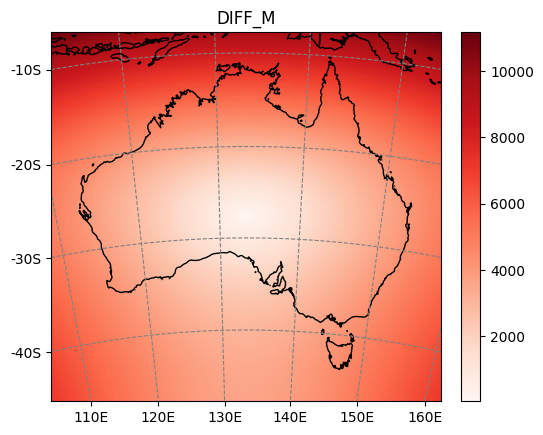

In [183]:
bad_xx, bad_yy = pyproj.transform(wgs_proj, bad_proj, ds.XLONG_M.values, ds.XLAT_M.values)
ds['DIFF_M'] = np.sqrt((bad_xx - xx)**2 + (bad_yy - yy)**2) + ds.XLONG_M*0 # trick
ds.salem.quick_map('DIFF_M', cmap='Reds');